# **Sentiment Analysis**

Sentiment analysis refers to analyzing opinions or feelings about something using data such as text or images, covering a wide range of subjects. Sentiment analysis plays a vital role in the decision-making process for companies. For instance, if the public sentiment towards a product is unfavorable, a company may consider modifying the product or even discontinuing its production to mitigate potential losses.

There are numerous sources of public sentiment, including public interviews, opinion polls, surveys, and more. However, with the increasing number of people joining social media platforms, websites like Facebook and Twitter can be leveraged to gather public sentiment.

# **Problem Definition**

Given tweets about six US airlines, the task is to predict whether a tweet contains positive, negative, or neutral sentiment about the airline. This is a typical supervised learning task where given a text string, we have to categorize the text string into predefined categories.

# **Solution**

To solve this problem, we will follow the standard machine learning pipeline. Firstly, we will import the necessary libraries and the dataset. Next, we will conduct exploratory data analysis to identify any trends within the dataset. Then, we will perform text preprocessing to convert the textual data into a numeric format suitable for machine learning algorithms. Finally, we will utilize machine learning algorithms to train and test our sentiment analysis models

***Import the necessary libraries***

In [1]:
!pip install emoji


In [2]:
import numpy as np

import pandas as pd

pd.set_option ('display.max_colwidth', -1)

from time import time

import os

import re

import string

import emoji

from pprint import pprint

import collections

import matplotlib.pyplot as plt

import seaborn as sns

sns.set (style="darkgrid")

sns.set (font_scale=1.3)

from sklearn.base import BaseEstimator, TransformerMixin

from sklearn. feature_extraction.text import CountVectorizer

from sklearn. feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline, FeatureUnion

from sklearn.metrics import classification_report

from sklearn.naive_bayes import MultinomialNB

from sklearn.linear_model import LogisticRegression

import joblib

import nltk

from nltk.corpus import stopwords

from nltk.stem import PorterStemmer

from nltk.tokenize import word_tokenize

import warnings
warnings.filterwarnings('ignore')

np.random.seed(37)

<ipython-input-2-0fe466bb86d0>:5: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option ('display.max_colwidth', -1)


***Load the Dataset***

In [3]:
airlines_train = pd.read_csv('Tweets.csv')


In [4]:
airlines_train.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials to the experience... tacky.,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I need to take another trip!,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing about it,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [5]:
airlines_train.columns

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')

In [6]:
airlines_train.isna().sum()

tweet_id                        0    
airline_sentiment               0    
airline_sentiment_confidence    0    
negativereason                  5462 
negativereason_confidence       4118 
airline                         0    
airline_sentiment_gold          14600
name                            0    
negativereason_gold             14608
retweet_count                   0    
text                            0    
tweet_coord                     13621
tweet_created                   0    
tweet_location                  4733 
user_timezone                   4820 
dtype: int64

In [7]:
airlines_train['airline'].value_counts()

United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America    504 
Name: airline, dtype: int64

# **Exploration Of Data**

***Let's see the number of tweets for each airline. We will plot a pie chart for that***

<Axes: ylabel='airline'>

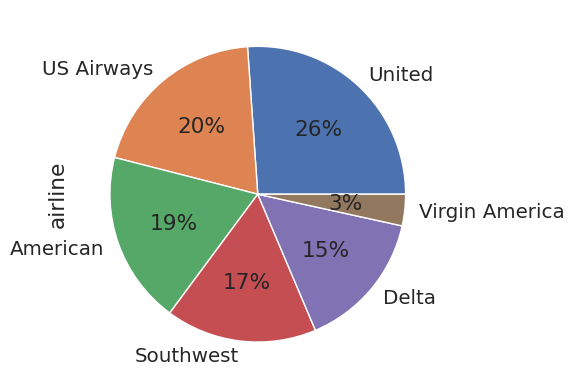

In [8]:
airlines_train.airline.value_counts().plot(kind='pie', autopct='%1.0f%%')


***Let's see the distribution of sentiments across all the tweets.***

<Axes: ylabel='airline_sentiment'>

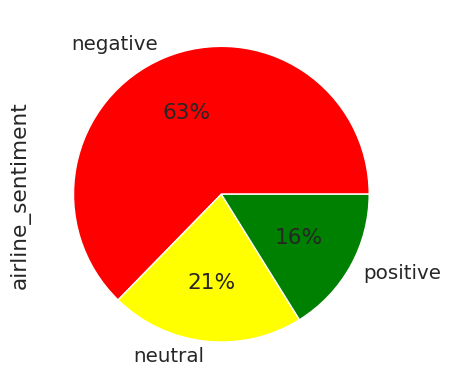

In [9]:
airlines_train.airline_sentiment.value_counts().plot(kind='pie', autopct='%1.0f%%', colors=["red", "yellow", "green"])


<Axes: xlabel='airline'>

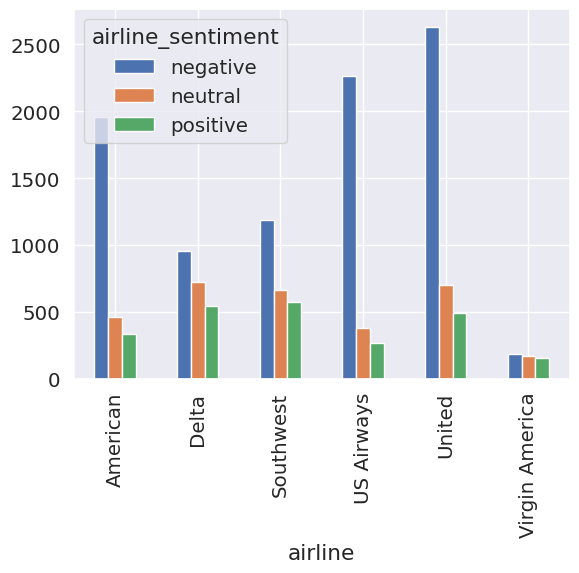

In [10]:
airline_sentiment = airlines_train.groupby(['airline', 'airline_sentiment']).airline_sentiment.count().unstack()
airline_sentiment.plot(kind='bar')

*It is evident from the output that for almost all the airlines, the majority of the tweets are negative, followed by neutral and positive tweets. Virgin America is probably the only airline where the ratio of the three sentiments is somewhat similar.italicized text*

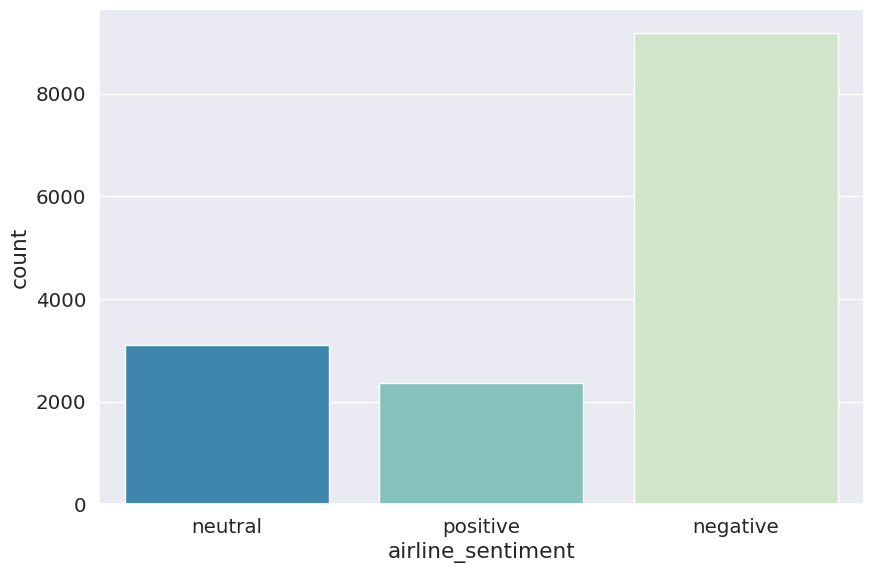

In [11]:

sns.catplot(x="airline_sentiment", data=airlines_train, kind="count", height=6, aspect=1.5, palette="GnBu_r")

plt.show();

*Above graph visualising a count plot, which shows the frequency of each category in the 'airline_sentiment' column.*

***Drop the unnecessary columns***

In [12]:
airlines_train= airlines_train.reindex (np.random.permutation (airlines_train.index))

airlines_train = airlines_train[['text', 'airline_sentiment']]

In [13]:
airlines_train

,text,airline_sentiment
10620,@USAirways told to work it out ourselves #joke #fail,negative
13609,@AmericanAir that all AA is for USAir Elite members. It's one big disappointment in the way we are treated. #epicfailure,negative
2955,@united Bummer. Might have to go with @AmericanAir card instead. TY for response though.,negative
3585,@united well the income flight to dca to take us to ewr was delayed and it made us miss our connection to FLL so yes hotels were necessary,negative
2087,@united we have tried to change our flight THREE times on the phone and got disconnected each time.,negative
...,...,...
988,@united done,neutral
14587,@AmericanAir I’ll play it by ear. I know that you are doing your best. Buy some chewey oatmeal cookies for your customer care folks.,negative
9036,"@USAirways I left my personal stuff on US4551 from PHL-BOS about an hour ago. Went baggage, was told plane left to call 800#",neutral
4459,"@SouthwestAir: Tried for VIP Live in The Vineyard but yr site went down, by the time I got in 2 redeem pts those packages gone.",negative


# **Data Cleaning**

*Tweets contain many slang words and punctuation marks. We need to clean our tweets before they can be used for training the machine learning model. So we use a custom text cleaning class called '**CleanText**'*

In [14]:
class CleanText(BaseEstimator, TransformerMixin):

    def remove_mentions (self, input_text):
      return re.sub(r'@\w+','', input_text)

    def remove_urls (self, input_text):
      return re.sub (r'http.?://[^\s]+[\s]?','', input_text)

    def emoji_oneword(self, input_text):
    #By compressing the underscore, the emoji is kept as one word
      return input_text.replace('_','')

    def remove_punctuation (self, input_text):
    #Make translation table
        punct= string.punctuation
        trantab= str.maketrans (punct, len (punct)*' ') # Every punctuation symbol will be replaced by a space
        return input_text.translate (trantab)

    def remove_digits (self, input_text):
      return re.sub('\d+', '', input_text)

    def to_lower (self, input_text):
      return input_text.lower()

    def remove_stopwords(self, input_text):
      stopwords_list = stopwords.words('english')
      # Some words which might indicate a certain sentiment are kept via a whitelist
      whitelist = ["n't", "not", "no"]
      words=input_text.split()
      clean_words =[word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1]
      return " ".join(clean_words)

    def stemming(self, input_text):
      porter = PorterStemmer ()
      words = input_text.split()
      stemmed_words = [porter.stem(word) for word in words]
      return " ".join(stemmed_words)

    def fit (self, X, y=None, **fit_params):
      return self

    def transform(self, X, **transform_params):
      clean_X = X.apply(self.remove_mentions).apply(self.remove_urls).apply(self.remove_punctuation).apply(self.remove_digits).apply(self.to_lower).apply(self.remove_stopwords).apply(self.stemming)
      return clean_X


Downloading the Natural Language Toolkit (NLTK) library which is used for text processing and data cleaning operations.

In [15]:
nltk.download ('punkt')

nltk.download('stopwords')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [16]:
ct= CleanText()

sr_clean = ct.fit_transform(airlines_train.text)



***Display cleaned text randomly***

In [17]:
sr_clean.sample(5)


12222    glad rt bet bird wish flown south winter                         
3936     point upc code check baggag tell luggag vacat day tri swimsuit   
367      vx jfk la dirti plane not standard                               
12257    tell mean work need estim time arriv pleas need laptop work thank
2957     sure busi go els airlin travel name kathryn sotelo               
Name: text, dtype: object

*Prints the number of records with no words after cleaning*

In [18]:
empty_clean =sr_clean ==''

print('{} records have no words left after text cleaning'.format (sr_clean[empty_clean].count()))


22 records have no words left after text cleaning


Replaces those empty strings with the string '[no_text]'

In [19]:

sr_clean.loc[empty_clean] = '[no_text]'

In [20]:
sr_clean

10620    told work joke fail                                                                
13609    aa usair elit member one big disappoint way treat epicfailur                       
2955     bummer might go card instead ty respons though                                     
3585     well incom flight dca take us ewr delay made us miss connect fll ye hotel necessari
2087     tri chang flight three time phone got disconnect time                              
                                 ...                                                        
988      done                                                                               
14587    i’ll play ear know best buy chewey oatmeal cooki custom care folk                  
9036     left person stuff us phl bo hour ago went baggag told plane left call              
4459     tri vip live vineyard yr site went time got redeem pt packag gone                  
1935     lie                                                          

Calculates the frequency count of each word in the cleaned text data using the bag-of-words representation with the CountVectorizer

In [21]:
cv=CountVectorizer()
bow= cv.fit_transform(sr_clean)
word_freq=dict(zip(cv.get_feature_names_out(),np.asarray(bow.sum(axis=0)).ravel()))
word_counter=collections.Counter(word_freq)
word_counter_df=pd.DataFrame(word_counter.most_common(20),columns=['word','freq'])

In [22]:
word_counter_df

,word,freq
0,flight,4879
1,thank,1703
2,get,1623
3,not,1586
4,no,1507
5,hour,1167
6,cancel,1065
7,help,1062
8,delay,1010
9,servic,1002


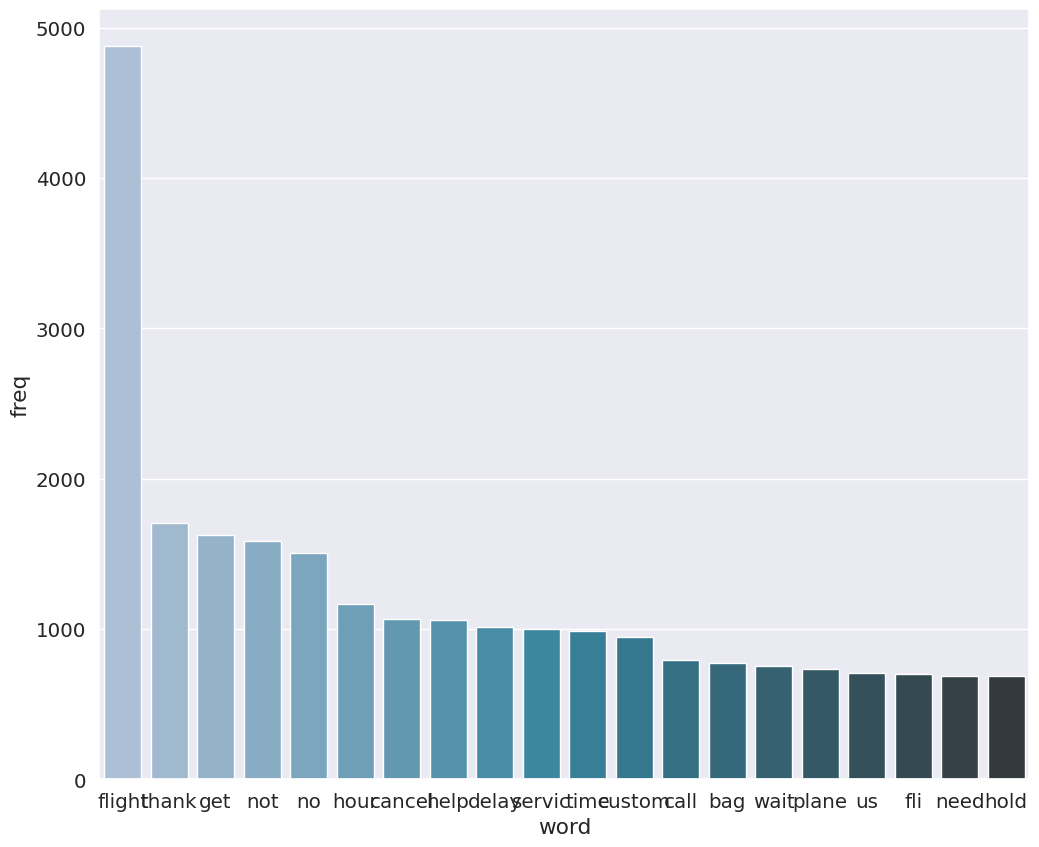

In [23]:

fig,ax=plt.subplots(figsize=(12,10))
sns.barplot(x="word",y="freq",data=word_counter_df,palette="PuBuGn_d",ax=ax)
plt.show();


*The above bar plot displays the top 20 most common words and their frequencies in the text data. Which can be helpful for understanding the content and characteristics of the text data.*

The **grid_vect** function is defined to perform grid search over a combination of classifier parameters and text vectorization parameters. The function aims to find the best combination of these parameters for a given classifier model and text data.

In [24]:
def grid_vect(clf,parameters_clf,X_train,X_test,parameters_text=None,vect=None,is_w2v=False):
  textcountscols=['count_capital_words','count_emojis','count_excl_quest_marks','count_hashtags'
                   ,'count_mentions','count_urls','count_words']

  if is_w2v:
    w2vcols=[]
    for i in range(SIZE):
        w2vcols.append(i)
    features=FeatureUnion([('textcounts',ColumnExtractor(cols=textcountscols))
                          ,('w2v',ColumnExtractor(cols=w2vcols))]
                          ,n_jobs=-1)
  else:
    features=FeatureUnion([('textcounts',ColumnExtractor(cols=textcountscols))
                           ,('pipe',Pipeline([('cleantext',ColumnExtractor(cols='clean_text')),('vect',vect)]))]
                         ,n_jobs=-1 )

  pipeline=Pipeline([('features',features)
                 ,('clf',clf)])


  #join the parameters dictionaries together
  parameters =dict()
  if parameters_text:
    parameters.update(parameters_text)
  parameters.update(parameters_clf)
  grid_search=GridSearchCV(pipeline,parameters,n_jobs=-1,verbose=1,cv=5,refit=True, error_score=0.0)

  print("Performing grid search....")
  print("pipeline:",[name for name, _ in pipeline.steps])
  print("Parameters:")
  pprint(parameters)
  t0=time()
  grid_search.fit(X_train,y_train)
  print("done in %0.3f" % (time() - t0))
  print()
  print("Best CV score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters=grid_search.best_estimator_.get_params()
  for param_name in sorted(parameters.keys()):
    print("\t%s : %r" % (param_name,best_parameters[param_name]))

  print("Test score with best_estimator_: %0.3f" % grid_search.best_estimator_.score(X_test,y_test))
  print("\n")
  print("Classification Report Test Data")
  print(classification_report(y_test,grid_search.best_estimator_.predict(X_test)))
  return grid_search



The **ColumnExtractor** transformer can be used within Scikit-learn pipelines to extract specific columns from the input data and pass only those columns to subsequent steps in the pipeline, enabling data selection and feature engineering as part of the pipeline's data processing flow.

In [25]:
class ColumnExtractor (TransformerMixin, BaseEstimator):
  def __init__(self, cols):
    self.cols = cols

  def fit(self, X, y=None, **fit_params):
    return self

  def transform(self, X, **transform_params):
    return X[self.cols]


The **TextCounts** transformer can be used within Scikit-learn pipelines to count specific text patterns in each document of the input data.

In [26]:
class TextCounts (BaseEstimator, TransformerMixin):

    def count_regex (self, pattern, tweet):
      return len(re.findall (pattern, tweet))

    def fit(self, X, y=None, **fit_params):
      return self    # fit method is used when specific operations need to be done on the train data, but not on the test data


    def transform(self, X, **transform_params):
      count_words = X.apply(lambda x: self.count_regex (r'\w+',x))
      count_mentions= X.apply(lambda x: self.count_regex (r'@\w+',x))
      count_hashtags = X.apply(lambda x: self.count_regex (r'#\w+', x))
      count_capital_words = X.apply(lambda x: self.count_regex(r'\b[A-Z]{2,}\b', x))
      count_excl_quest_marks=X.apply(lambda x:self.count_regex(r'!|\?',x))
      count_urls=X.apply(lambda x:self.count_regex(r'http.?://[^\s]+[\s]?',x))
      count_emojis=X.apply(lambda x:emoji.demojize(x)).apply(lambda x:self.count_regex(r':[a-z_&]+:',x))

      df =pd.DataFrame({'count_words' :count_words

                   ,'count_mentions': count_mentions
                   ,'count_hashtags': count_hashtags
                   ,'count_capital_words':count_capital_words
                   ,'count_excl_quest_marks':count_excl_quest_marks
                   ,'count_urls': count_urls
                   ,'count_emojis': count_emojis
                       })

      return df


In [27]:
tc = TextCounts()
airlines_eda=tc.fit_transform(airlines_train.text)
airlines_eda['airline_sentiment']=airlines_train.airline_sentiment



In [28]:
df_model = airlines_eda

df_model['clean_text'] = sr_clean

The **df_model** will be a DataFrame that contains the counts of various text patterns (extracted by the **TextCounts** transformer) for each text document, along with the '**clean_text**' column that holds the preprocessed text data obtained from the CleanText transformer.

In [29]:
df_model

,count_words,count_mentions,count_hashtags,count_capital_words,count_excl_quest_marks,count_urls,count_emojis,airline_sentiment,clean_text
10620,9,1,2,0,0,0,0,negative,told work joke fail
13609,21,1,1,1,0,0,0,negative,aa usair elit member one big disappoint way treat epicfailur
2955,14,2,0,1,0,0,0,negative,bummer might go card instead ty respons though
3585,28,1,0,1,0,0,0,negative,well incom flight dca take us ewr delay made us miss connect fll ye hotel necessari
2087,18,1,0,1,0,0,0,negative,tri chang flight three time phone got disconnect time
...,...,...,...,...,...,...,...,...,...
988,2,1,0,0,0,0,0,neutral,done
14587,25,1,0,0,0,0,0,negative,i’ll play ear know best buy chewey oatmeal cooki custom care folk
9036,24,1,0,2,0,0,0,neutral,left person stuff us phl bo hour ago went baggag told plane left call
4459,25,1,0,1,0,0,0,negative,tri vip live vineyard yr site went time got redeem pt packag gone


In [30]:
df_model.columns.tolist()

['count_words',
 'count_mentions',
 'count_hashtags',
 'count_capital_words',
 'count_excl_quest_marks',
 'count_urls',
 'count_emojis',
 'airline_sentiment',
 'clean_text']

* Divide our data into training and testing sets. The training set will be used to train the algorithm while the test set will be used to evaluate the performance of the machine learning model.*

In [31]:
X_train, X_test, y_train, y_test = train_test_split(df_model.drop ('airline_sentiment', axis=1), df_model.airline_sentiment,test_size=0.1, random_state=37)

 creating 4 classifier instances (mnb, logreg, countvect and tfidfvect) are created using the classes from Scikit-learn for Multinomial Naive Bayes, Logistic Regression, and CountVectorizer respectively.

In [32]:

mnb = MultinomialNB()

logreg= LogisticRegression()

countvect=CountVectorizer()

tfidfvect = TfidfVectorizer()


*Parameter grid settings for the vectorizers (Count and TFIDF)*


In [33]:
parameters_vect = {'features__pipe__vect__max_df': (0.25, 0.5),
                   'features__pipe__vect__ngram_range': ((1, 1), (1, 2)),
                   'features__pipe__vect__min_df': (1,2)}

#Parameter grid settings for Multinomial NB
parameters_mnb = { 'clf__alpha': (0.25, 0.5)}

 # Parameter grid settings for LogisticRegression
parameters_logreg = {
                      'clf__C': (0.25,1.0),
                      'clf__penalty':('l1','l2')}

# **Hyperparameter Tuning**

 The **Multinomial Naive Bayes** classifier (mnb) is used in combination with the **CountVectorizer** (countvect) to perform grid search for finding the best hyperparameters for the classifier.

In [34]:
 # Multinomial NB using Count vectorizer

best_mnb_countvect = grid_vect (mnb, parameters_mnb, X_train, X_test, parameters_text=parameters_vect, vect=countvect)


Performing grid search....
pipeline: ['features', 'clf']
Parameters:
{'clf__alpha': (0.25, 0.5),
 'features__pipe__vect__max_df': (0.25, 0.5),
 'features__pipe__vect__min_df': (1, 2),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 16 candidates, totalling 80 fits
done in 47.658

Best CV score: 0.776
Best parameters set:
	clf__alpha : 0.5
	features__pipe__vect__max_df : 0.5
	features__pipe__vect__min_df : 2
	features__pipe__vect__ngram_range : (1, 2)
Test score with best_estimator_: 0.784


Classification Report Test Data
              precision    recall  f1-score   support

    negative       0.82      0.91      0.86       911
     neutral       0.66      0.48      0.56       320
    positive       0.77      0.72      0.74       233

    accuracy                           0.78      1464
   macro avg       0.75      0.70      0.72      1464
weighted avg       0.77      0.78      0.77      1464



 The **Multinomial Naive Bayes** classifier (mnb) is used in combination with the **TF-IDF Vectorizer** (tfidfvect) to perform grid search for finding the best hyperparameters for the classifier.

In [35]:

# Multinomial NB using TFIDF

best_mnb_tfidf = grid_vect (mnb, parameters_mnb, X_train, X_test, parameters_text=parameters_vect, vect=tfidfvect)


Performing grid search....
pipeline: ['features', 'clf']
Parameters:
{'clf__alpha': (0.25, 0.5),
 'features__pipe__vect__max_df': (0.25, 0.5),
 'features__pipe__vect__min_df': (1, 2),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 16 candidates, totalling 80 fits
done in 27.955

Best CV score: 0.748
Best parameters set:
	clf__alpha : 0.25
	features__pipe__vect__max_df : 0.25
	features__pipe__vect__min_df : 2
	features__pipe__vect__ngram_range : (1, 2)
Test score with best_estimator_: 0.750


Classification Report Test Data
              precision    recall  f1-score   support

    negative       0.74      0.97      0.84       911
     neutral       0.76      0.29      0.42       320
    positive       0.80      0.50      0.62       233

    accuracy                           0.75      1464
   macro avg       0.77      0.59      0.63      1464
weighted avg       0.76      0.75      0.72      1464



 The **LogisticRegression** classifier (logreg) is used in combination with the **CountVectorizer** (countvect) to perform grid search for finding the best hyperparameters for the classifier.

In [36]:
# LogisticRegression using Count vectorizer

best_logreg_countvect = grid_vect(logreg, parameters_logreg, X_train, X_test, parameters_text=parameters_vect, vect=countvect)


Performing grid search....
pipeline: ['features', 'clf']
Parameters:
{'clf__C': (0.25, 1.0),
 'clf__penalty': ('l1', 'l2'),
 'features__pipe__vect__max_df': (0.25, 0.5),
 'features__pipe__vect__min_df': (1, 2),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 32 candidates, totalling 160 fits
done in 148.448

Best CV score: 0.789
Best parameters set:
	clf__C : 0.25
	clf__penalty : 'l2'
	features__pipe__vect__max_df : 0.25
	features__pipe__vect__min_df : 1
	features__pipe__vect__ngram_range : (1, 2)
Test score with best_estimator_: 0.794


Classification Report Test Data
              precision    recall  f1-score   support

    negative       0.83      0.91      0.87       911
     neutral       0.70      0.52      0.59       320
    positive       0.74      0.70      0.72       233

    accuracy                           0.79      1464
   macro avg       0.76      0.71      0.73      1464
weighted avg       0.79      0.79      0.79      1464



 The **LogisticRegression** classifier (logreg) is used in combination with the **TF-IDF Vectorizer** (tfidfvect) to perform grid search for finding the best hyperparameters for the classifier.

In [37]:

# LigisticRegression using TFIDF

best_logreg_tfidf = grid_vect (logreg, parameters_logreg, X_train, X_test, parameters_text=parameters_vect, vect=tfidfvect)

Performing grid search....
pipeline: ['features', 'clf']
Parameters:
{'clf__C': (0.25, 1.0),
 'clf__penalty': ('l1', 'l2'),
 'features__pipe__vect__max_df': (0.25, 0.5),
 'features__pipe__vect__min_df': (1, 2),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 32 candidates, totalling 160 fits
done in 130.978

Best CV score: 0.758
Best parameters set:
	clf__C : 1.0
	clf__penalty : 'l2'
	features__pipe__vect__max_df : 0.25
	features__pipe__vect__min_df : 2
	features__pipe__vect__ngram_range : (1, 1)
Test score with best_estimator_: 0.753


Classification Report Test Data
              precision    recall  f1-score   support

    negative       0.78      0.92      0.84       911
     neutral       0.66      0.41      0.51       320
    positive       0.70      0.56      0.62       233

    accuracy                           0.75      1464
   macro avg       0.71      0.63      0.66      1464
weighted avg       0.74      0.75      0.74      1464



**Support Vector Machine**

In [38]:
from sklearn.svm import SVC
svm = SVC(kernel='rbf', random_state=42)

In [39]:
# Parameter grid settings for SVM
parameters_svm = {
    'clf__gamma': ('scale', 'auto')

}


**SVM** with **count vectorizer**

In [40]:
best_svm_countvect = grid_vect (svm,parameters_svm, X_train, X_test, parameters_text=parameters_vect, vect=countvect)

Performing grid search....
pipeline: ['features', 'clf']
Parameters:
{'clf__gamma': ('scale', 'auto'),
 'features__pipe__vect__max_df': (0.25, 0.5),
 'features__pipe__vect__min_df': (1, 2),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 16 candidates, totalling 80 fits
done in 916.212

Best CV score: 0.706
Best parameters set:
	clf__gamma : 'scale'
	features__pipe__vect__max_df : 0.25
	features__pipe__vect__min_df : 1
	features__pipe__vect__ngram_range : (1, 2)
Test score with best_estimator_: 0.697


Classification Report Test Data
              precision    recall  f1-score   support

    negative       0.71      0.95      0.81       911
     neutral       0.48      0.18      0.26       320
    positive       0.76      0.43      0.55       233

    accuracy                           0.70      1464
   macro avg       0.65      0.52      0.54      1464
weighted avg       0.67      0.70      0.65      1464



**SVM** with **TF-IDF Vectorizer**

In [41]:
best_svm_tfidf = grid_vect (svm,parameters_svm, X_train, X_test, parameters_text=parameters_vect, vect=tfidfvect)

Performing grid search....
pipeline: ['features', 'clf']
Parameters:
{'clf__gamma': ('scale', 'auto'),
 'features__pipe__vect__max_df': (0.25, 0.5),
 'features__pipe__vect__min_df': (1, 2),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 16 candidates, totalling 80 fits
done in 985.073

Best CV score: 0.653
Best parameters set:
	clf__gamma : 'scale'
	features__pipe__vect__max_df : 0.25
	features__pipe__vect__min_df : 2
	features__pipe__vect__ngram_range : (1, 1)
Test score with best_estimator_: 0.651


Classification Report Test Data
              precision    recall  f1-score   support

    negative       0.66      0.98      0.79       911
     neutral       0.44      0.12      0.19       320
    positive       0.86      0.11      0.19       233

    accuracy                           0.65      1464
   macro avg       0.65      0.40      0.39      1464
weighted avg       0.64      0.65      0.56      1464



**Random Forest Classifier**

In [42]:
from sklearn.ensemble import RandomForestClassifier

rfc= RandomForestClassifier(random_state=0)

In [43]:
# Parameter grid settings for Random Forest Classifier
parameters_rf = {
    'clf__n_estimators': (50,100)  # Number of trees in the forest

}

**Random Forest** with **Countvectorizer**

In [44]:
best_rfc_countvect = grid_vect(rfc, parameters_rf, X_train, X_test, parameters_text=parameters_vect, vect=countvect)


Performing grid search....
pipeline: ['features', 'clf']
Parameters:
{'clf__n_estimators': (50, 100),
 'features__pipe__vect__max_df': (0.25, 0.5),
 'features__pipe__vect__min_df': (1, 2),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 16 candidates, totalling 80 fits
done in 1244.570

Best CV score: 0.769
Best parameters set:
	clf__n_estimators : 100
	features__pipe__vect__max_df : 0.25
	features__pipe__vect__min_df : 2
	features__pipe__vect__ngram_range : (1, 1)
Test score with best_estimator_: 0.784


Classification Report Test Data
              precision    recall  f1-score   support

    negative       0.79      0.96      0.86       911
     neutral       0.75      0.41      0.53       320
    positive       0.80      0.63      0.71       233

    accuracy                           0.78      1464
   macro avg       0.78      0.66      0.70      1464
weighted avg       0.78      0.78      0.76      1464



**Random Forest** with **TF-IDF vectorizer**

In [45]:
best_rfc_tfidf = grid_vect(rfc, parameters_rf, X_train, X_test, parameters_text=parameters_vect, vect=tfidfvect)


Performing grid search....
pipeline: ['features', 'clf']
Parameters:
{'clf__n_estimators': (50, 100),
 'features__pipe__vect__max_df': (0.25, 0.5),
 'features__pipe__vect__min_df': (1, 2),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 16 candidates, totalling 80 fits
done in 1161.820

Best CV score: 0.770
Best parameters set:
	clf__n_estimators : 100
	features__pipe__vect__max_df : 0.25
	features__pipe__vect__min_df : 1
	features__pipe__vect__ngram_range : (1, 2)
Test score with best_estimator_: 0.779


Classification Report Test Data
              precision    recall  f1-score   support

    negative       0.78      0.96      0.86       911
     neutral       0.75      0.42      0.54       320
    positive       0.83      0.56      0.67       233

    accuracy                           0.78      1464
   macro avg       0.78      0.65      0.69      1464
weighted avg       0.78      0.78      0.76      1464



In [46]:
from tabulate import tabulate

# Test scores data
data = [
    ["countvect", 0.784, 0.794, 0.697, 0.782],
    ["tfidf", 0.750, 0.753, 0.651, 0.779]
]

# Column headers
headers = ["", "mnb", "log", "svm", "rfc"]

# Print the formatted table
table = tabulate(data, headers=headers, tablefmt="grid")
print("Test score's with best estimator")
print(table)


Test score's with best estimator
+-----------+-------+-------+-------+-------+
|           |   mnb |   log |   svm |   rfc |
+===========+=======+=======+=======+=======+
| countvect | 0.784 | 0.794 | 0.697 | 0.782 |
+-----------+-------+-------+-------+-------+
| tfidf     | 0.75  | 0.753 | 0.651 | 0.779 |
+-----------+-------+-------+-------+-------+


***LogisticRegression*** using ***Count vectorizer*** shows **best test score** of **0.794** among others

Save the model to a file

In [47]:


output_directory = 'C:/Users/HP/Desktop/sentiment_analysis_webapp/models'
output_filename = 'best_logreg_countvect.pkl'

# Create the directory if it doesn't exist
os.makedirs(output_directory, exist_ok=True)

output_path = os.path.join(output_directory, output_filename)

joblib.dump(best_logreg_countvect, output_path)



['C:/Users/HP/Desktop/sentiment_analysis_webapp/models/best_logreg_countvect.pkl']

Load the model using joblib


In [48]:


# Path to the saved model file
model_path = 'C:/Users/HP/Desktop/sentiment_analysis_webapp/models/best_logreg_countvect.pkl'

loaded_model = joblib.load(model_path)



Predict a sample tweet using loaded model

In [50]:
# Preprocess the tweet using a function

def preprocess_tweet(tweet):
    # Apply the same cleaning steps as done on the training data
    cleaned_tweet = ct.transform(pd.Series(tweet))

    # Extract the text counts features from the tweet
    tweet_counts = tc.transform(pd.Series(tweet))

    # Combine the text counts features with the cleaned text
    tweet_data = pd.concat([tweet_counts, pd.Series(cleaned_tweet, name='clean_text')], axis=1)

    return tweet_data



In [51]:
text = "I had a great flight with the airline!"


tweet_sample= preprocess_tweet(text)
prediction = loaded_model.predict(tweet_sample)[0]
print("Predicted Sentiment:", prediction)


Predicted Sentiment: positive


Train the Best Model on the Entire Dataset


In [52]:
best_logreg_countvect.best_estimator_.fit(df_model.drop('airline_sentiment', axis=1), df_model.airline_sentiment)

Pipeline(steps=[('features',
                 FeatureUnion(n_jobs=-1,
                              transformer_list=[('textcounts',
                                                 ColumnExtractor(cols=['count_capital_words',
                                                                       'count_emojis',
                                                                       'count_excl_quest_marks',
                                                                       'count_hashtags',
                                                                       'count_mentions',
                                                                       'count_urls',
                                                                       'count_words'])),
                                                ('pipe',
                                                 Pipeline(steps=[('cleantext',
                                                                  ColumnExtractor(cols='clean_text')),
                                                                 ('vect',
                                                                  CountVectorizer(max_df=0.25,
                                                                                  ngram_range=(1,
                                                                                               2)))]))])),
                ('clf', LogisticRegression(C=0.25))])

*Evaluate Model Performance,
  Splitting the data into training and validation sets*

In [53]:
x_train, x_val, y_train, y_val = train_test_split(df_model.drop('airline_sentiment', axis=1), df_model.airline_sentiment, test_size=0.2, random_state=42)

Training the best model on the training set

In [54]:
best_logreg_countvect.best_estimator_.fit(x_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(n_jobs=-1,
                              transformer_list=[('textcounts',
                                                 ColumnExtractor(cols=['count_capital_words',
                                                                       'count_emojis',
                                                                       'count_excl_quest_marks',
                                                                       'count_hashtags',
                                                                       'count_mentions',
                                                                       'count_urls',
                                                                       'count_words'])),
                                                ('pipe',
                                                 Pipeline(steps=[('cleantext',
                                                                  ColumnExtractor(cols='clean_text')),
                                                                 ('vect',
                                                                  CountVectorizer(max_df=0.25,
                                                                                  ngram_range=(1,
                                                                                               2)))]))])),
                ('clf', LogisticRegression(C=0.25))])

In [55]:
# # Evaluating the model on the validation set
validation_accuracy = best_logreg_countvect.score(x_val, y_val)
print("Validation Accuracy: {:.3f}".format(validation_accuracy))

Validation Accuracy: 0.783


To check example tweet prediction, we need to preprocess the tweet

# **Predict using Logistic Regression with CountVectorizer**

In [56]:
# Example tweet for prediction
example_tweet = "I had a great flight with @airlineXYZ! 😊 #happytravel"

# Preprocess the example tweet for prediction
preprocessed_example_tweet = preprocess_tweet(example_tweet)


logreg_countvect_prediction = best_logreg_countvect.predict(preprocessed_example_tweet)
print("The sentiment of the tweet is :", logreg_countvect_prediction[0])



The sentiment of the tweet is : positive


In [57]:
sample_tweet = "I had a bad experience with the airline. The staff was not friendly and not helpful."
logreg_countvect_predict = best_logreg_countvect.predict(preprocess_tweet(sample_tweet))
print("The sentiment of the tweet is :", logreg_countvect_predict[0])

The sentiment of the tweet is : negative


In [58]:

sample_tweet = "@VirginAmerica Really missed a prime opportunity for Men Without Hats parody, there. https://t.co/mWpG7grEZP"
logreg_countvect_predict = best_logreg_countvect.predict(preprocess_tweet(sample_tweet))
print("The sentiment of the tweet is :", logreg_countvect_predict[0])

The sentiment of the tweet is : negative


In [59]:

sample_tweet = "@virginamerica Well, I didn't…but NOW I DO! :-D"
logreg_countvect_predict = best_logreg_countvect.predict(preprocess_tweet(sample_tweet))
print("The sentiment of the tweet is :", logreg_countvect_predict[0])

The sentiment of the tweet is : positive


In [60]:
sample_tweet = "@virginamerica Well, I didn't…but NOW I DO! :-D"
logreg_countvect_predict = best_logreg_countvect.predict(preprocess_tweet(sample_tweet))
print("The sentiment of the tweet is :", logreg_countvect_predict[0])

The sentiment of the tweet is : positive


In [61]:
sample_tweet = "Heading to work now. Mondays are always busy."
logreg_countvect_predict = best_logreg_countvect.predict(preprocess_tweet(sample_tweet))
print("The sentiment of the tweet is :", logreg_countvect_predict[0])

The sentiment of the tweet is : negative


In [64]:
sample_tweet = "  "
logreg_countvect_predict = best_logreg_countvect.predict(preprocess_tweet(sample_tweet))
print("The sentiment of the tweet is :", logreg_countvect_predict[0])

The sentiment of the tweet is : neutral


In [65]:
sample_tweet = "i don't know"
logreg_countvect_predict = best_logreg_countvect.predict(preprocess_tweet(sample_tweet))
print("The sentiment of the tweet is :", logreg_countvect_predict[0])

The sentiment of the tweet is : neutral
